Timestep 900.0000 ss
Run time 184.15s/3.07m
[0.10000000000002274, 0.11203207829433381, 0.12389171728511883, 0.13601120777863684, 0.1481913362034959, 0.16030938779397275, 0.1723376189568171, 0.18423422226007347, 0.19624878932711454, 0.20850173888675272, 0.22067680771829146, 0.2328039088525884, 0.24495116505198666, 0.25684355852675367, 0.2689760105992889, 0.28139459986127235, 0.293407857553575, 0.3053266550404601, 0.31732307581381747, 0.3291731818845278, 0.34135606858205847, 0.35372926106455793, 0.36585110663042997, 0.37803671096759217, 0.3900812753042828, 0.40207877828564165, 0.41413684482060376, 0.426491816567534, 0.43848009616493755, 0.4502532772187351, 0.4622591598285908, 0.47422476293229465, 0.4864858159746177, 0.49901712797449704, 0.5110249530047497, 0.5228053636104733, 0.5348832817026619, 0.5468948329731802, 0.5592952699817602, 0.5720142037444305, 0.5838982438592097, 0.595461946378407, 0.6074317821133945, 0.619343970528007, 0.63165919151092, 0.6443048466367145, 0.6561685951221818,

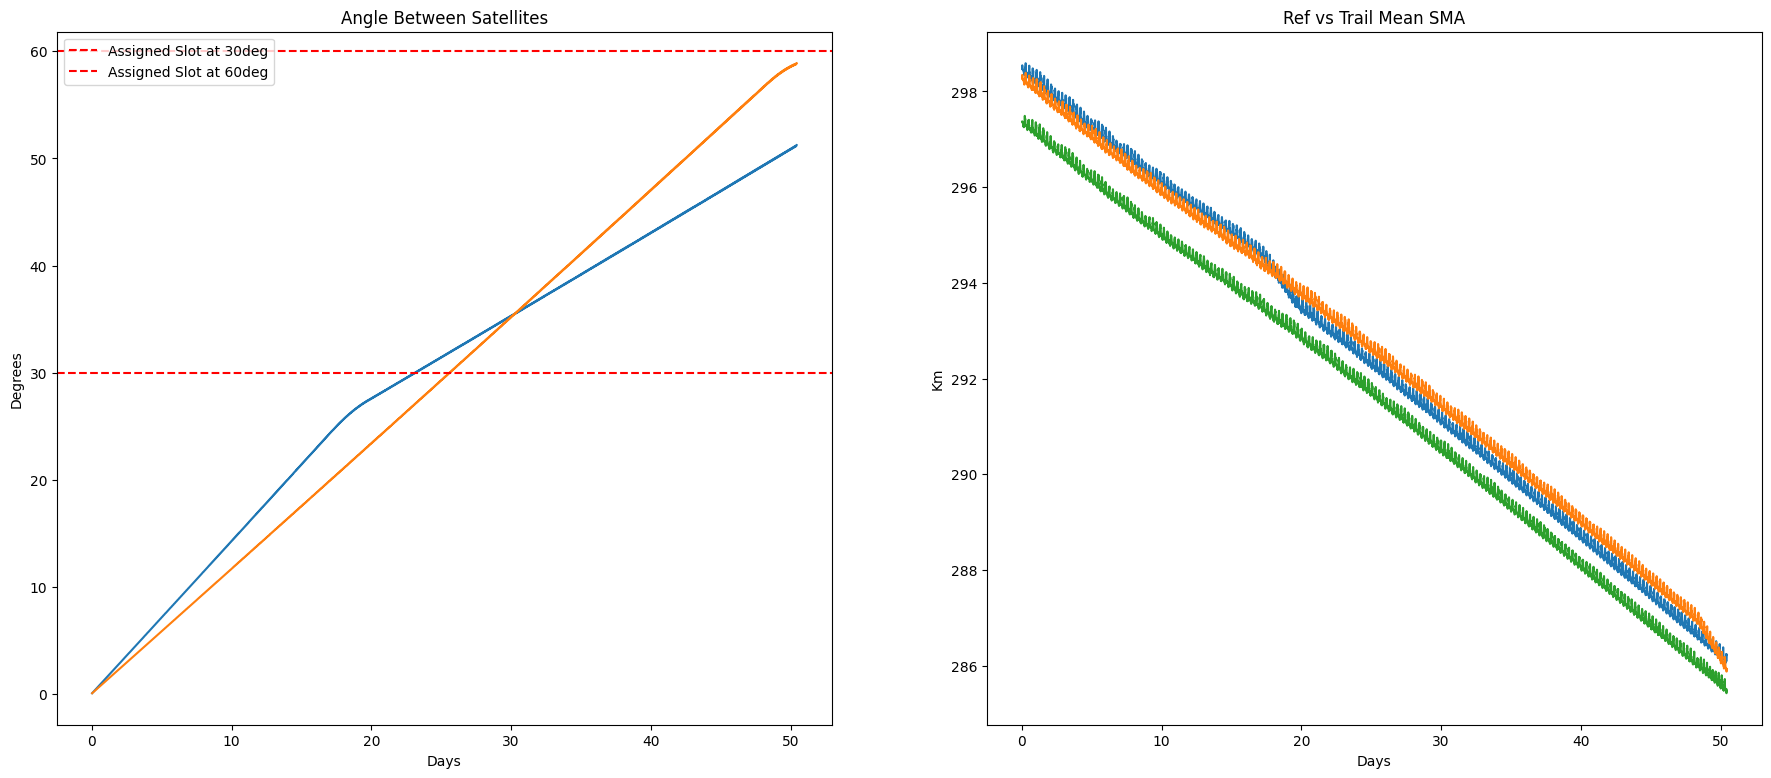

In [20]:
import time

import numpy as np

import matplotlib.pyplot as plt

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.constants import R_earth
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time, TimeDelta

from datetime import datetime
from osc2mean_dd import osc2mean
from sso_inc import inc_from_alt, raan_from_ltan, argl_difference
from perturbations import perturbations_coesa_J2_low, perturbations_coesa_J2_high


toc = time.time()

## Orbit
h = 300
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

assignment = [30, 60]
delta_a = [1.1,0.9]
delta_nu = [-0.1,-0.1]

epoch = Time(val=start_date.isoformat(), format='isot')
time_step = 900<<u.s
pred_days = 10

refsmalist = []
refsmalist_mean = []

trail_sats = 2
trailsmalist = [[],[]]
trailsmalist_mean = [[],[]]
trailing_orbit = [[],[]]

elapsedsecs = [[],[]]
angle_list = [[],[]]

start_date_prop = epoch

for sat in range(trail_sats):
    secs = 0

    reference_orbit = Orbit.from_classical(
        Earth,
        a,
        ecc,
        inc,
        raan,
        argp,
        nu,
        epoch
        )
    trailing_orbit = Orbit.from_classical(
        Earth,
        (a.value+delta_a[sat])<<u.km,
        ecc,
        inc,
        raan,
        argp,
        (nu.value+delta_nu[sat])<<u.deg,
        epoch
        )

    ref_mean = osc2mean(a.value, ecc.value, inc.value, raan.value, argp.value, nu.value)
    ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, nu, epoch)
    trail_mean = osc2mean(a.value+delta_a[sat], ecc.value, inc.value, raan.value, argp.value, nu.value+delta_nu[sat])
    trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, nu+(delta_nu[sat]<<u.deg), epoch)

    theta_err = (assignment[sat] - argl_difference(reference_orbit, trailing_orbit))%360
    
    tra_orb_pred = trailing_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high))
    tra_pred_mean = osc2mean(tra_orb_pred.a.value, tra_orb_pred.ecc.value, tra_orb_pred.inc.to_value(u.deg), tra_orb_pred.raan.to_value(u.deg), tra_orb_pred.argp.to_value(u.deg), tra_orb_pred.nu.to_value(u.deg))
    tra_orb_pred_mean = Orbit.from_classical(Earth, tra_pred_mean[0]<<u.km, tra_pred_mean[1]<<u.one, tra_pred_mean[2]<<u.deg, tra_pred_mean[3]<<u.deg, tra_pred_mean[4]<<u.deg, tra_orb_pred.nu.to(u.deg), tra_orb_pred.epoch)
    
    theta_dot_dot = (tra_orb_pred_mean.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / ((pred_days*60*60*24)<<u.s)
    t_hd = (ref_mean_orbit.n.to(u.deg/u.s) - trail_mean_orbit.n.to(u.deg/u.s)) / theta_dot_dot
    theta_hd = 0.5 * theta_dot_dot * t_hd**2
    t_wait = ((theta_err - theta_hd.value) / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s))) - t_hd.value 
    if t_wait < 0:
        t_wait = t_wait + t_hd.value     

    num_wait = int(t_wait / time_step.value)
    tofs_wait = TimeDelta(np.linspace(0, t_wait<<u.s, num=num_wait))
    reference_ephem = reference_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(start_date_prop + tofs_wait, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))


    for t in range(len(tofs_wait)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        if sat > 0:
            refsmalist.append(ref_from_ephem.a.value)
        trailsmalist[sat].append(trail_from_ephem.a.value)

        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        if sat > 0:
            refsmalist_mean.append(ref_mean[0])
        trailsmalist_mean[sat].append(trail_mean[0])
        
        angle_list[sat].append(argl_difference(ref_from_ephem, trail_from_ephem))

        elapsedsecs[sat].append(secs)
    
    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])


    num_hd = int(t_hd.value / time_step.value)
    tofs_hd = TimeDelta(np.linspace(0, t_hd, num=num_hd))

    reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
    trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_ephem.epochs[-1] + tofs_hd, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high)))


    for t in range(len(tofs_hd)):

        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

        if sat > 0:
            refsmalist.append(ref_from_ephem.a.value)
        trailsmalist[sat].append(trail_from_ephem.a.value)

        ref_mean = osc2mean(
            ref_from_ephem.a.value,
            ref_from_ephem.ecc.value,
            ref_from_ephem.inc.to_value(u.deg),
            ref_from_ephem.raan.to_value(u.deg),
            ref_from_ephem.argp.to_value(u.deg),
            ref_from_ephem.nu.to_value(u.deg)

        )
        trail_mean = osc2mean(
            trail_from_ephem.a.value,
            trail_from_ephem.ecc.value,
            trail_from_ephem.inc.to_value(u.deg),
            trail_from_ephem.raan.to_value(u.deg),
            trail_from_ephem.argp.to_value(u.deg),
            trail_from_ephem.nu.to_value(u.deg)
        )

        if sat > 0:
            refsmalist_mean.append(ref_mean[0])
        trailsmalist_mean[sat].append(trail_mean[0])
        
        angle_list[sat].append(argl_difference(ref_from_ephem, trail_from_ephem))

        elapsedsecs[sat].append(secs)

    reference_orbit = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
    trailing_orbit = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])


    ref_mean = osc2mean(
        reference_orbit.a.value, 
        reference_orbit.ecc.value, 
        reference_orbit.inc.to_value(u.deg), 
        reference_orbit.raan.to_value(u.deg), 
        reference_orbit.argp.to_value(u.deg), 
        reference_orbit.nu.to_value(u.deg)
        )
    ref_mean_orbit = Orbit.from_classical(
                                          Earth, 
                                          ref_mean[0]<<u.km, 
                                          ref_mean[1]<<u.one, 
                                          ref_mean[2]<<u.deg, 
                                          ref_mean[3]<<u.deg, 
                                          ref_mean[4]<<u.deg, 
                                          reference_orbit.nu.to(u.deg), 
                                          reference_orbit.epoch
                                          )

    trail_mean = osc2mean(
        trailing_orbit.a.value, 
        trailing_orbit.ecc.value, 
        trailing_orbit.inc.to_value(u.deg), 
        trailing_orbit.raan.to_value(u.deg), 
        trailing_orbit.argp.to_value(u.deg), 
        trailing_orbit.nu.to_value(u.deg)
        )
    trail_mean_orbit = Orbit.from_classical(
                                            Earth, 
                                            trail_mean[0]<<u.km, 
                                            trail_mean[1]<<u.one, 
                                            trail_mean[2]<<u.deg, 
                                            trail_mean[3]<<u.deg, 
                                            trail_mean[4]<<u.deg, 
                                            trailing_orbit.nu.to(u.deg), 
                                            trailing_orbit.epoch
                                            )
    if sat == 0:
        reference_orbit_short = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
        short_time = 0
        trailing_orbit_short = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])
    elif sat>0 and elapsedsecs[sat]<elapsedsecs[sat-1]:
        reference_orbit_short = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[-1])
        short_time = sat
        trailing_orbit_short = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[-1])

t_prop = (elapsedsecs[short_time-1][-1] - elapsedsecs[short_time][-1])<<u.s
num_prop = int(t_prop.value / time_step.value)
tofs_prop = TimeDelta(np.linspace(0, t_prop, num=num_prop))

reference_ephem = reference_orbit_short.to_ephem(EpochsArray(reference_orbit_short.epoch + tofs_prop, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
trailing_ephem = trailing_orbit_short.to_ephem(EpochsArray(trailing_orbit_short.epoch + tofs_prop, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))

for t in range(len(tofs_prop)):

    ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
    trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

    trailsmalist[short_time].append(trail_from_ephem.a.value)

    trail_mean = osc2mean(
        trail_from_ephem.a.value,
        trail_from_ephem.ecc.value,
        trail_from_ephem.inc.to_value(u.deg),
        trail_from_ephem.raan.to_value(u.deg),
        trail_from_ephem.argp.to_value(u.deg),
        trail_from_ephem.nu.to_value(u.deg)
    )

    trailsmalist_mean[short_time].append(trail_mean[0])

    angle_list[short_time].append(argl_difference(ref_from_ephem, trail_from_ephem))


elapsed_days = []
for sec in range(len(elapsedsecs[1])):
    elapsed_days.append(elapsedsecs[1][sec]/(60*60*24))

ref_mean_altitudes = []
for sma in range(len(refsmalist_mean)):
    ref_mean_altitudes.append(refsmalist_mean[sma] - Earth.R_mean.to_value(u.km))

trail_mean_altitudes = [[],[]]
for sat in range(trail_sats):
    for sma in range(len(trailsmalist_mean[sat])):
        trail_mean_altitudes[sat].append(trailsmalist_mean[sat][sma] - Earth.R_mean.to_value(u.km))


fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,angle_list[0])
ax[0,0].plot(elapsed_days,angle_list[1])
ax[0,0].axhline(assignment[0],linestyle='--',color='red',label = f'Assigned Slot at {assignment[0]}deg')
ax[0,0].axhline(assignment[1],linestyle='--',color='red',label = f'Assigned Slot at {assignment[1]}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Degrees')

ax[0,1].plot(elapsed_days,trail_mean_altitudes[0],label='Trail')
ax[0,1].plot(elapsed_days,trail_mean_altitudes[1],label='Trail')
ax[0,1].plot(elapsed_days,ref_mean_altitudes,label='Ref')
ax[0,1].set_title('Ref vs Trail Mean SMA')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
print(angle_list[-1])
plt.show()










In [16]:
assignment[0]

30

In [13]:
elapsedsecs[1][-1]- elapsedsecs[0][-1]

2043000.0

3929400.0